In [1]:
import os
os.chdir('/home/zongchen/nest_bq')
import pandas as pd
import numpy as np
import jax
import matplotlib.pyplot as plt

from utils.kernel_means import *

rng_key = jax.random.PRNGKey(0)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
class Kernel:
    def __init__(self, length_scale=1.0, variance=1.0, kernel_type='rbf'):
        self.length_scale = length_scale
        self.variance = variance
        self.kernel_type = kernel_type
    
    def compute(self, x1, x2):
        """
        Compute the kernel matrix between x1 and x2 based on the specified kernel type.
        """
        x1 = np.asarray(x1)
        x2 = np.asarray(x2)
        
        if self.kernel_type == 'rbf':
            return self._squared_exponential(x1, x2)
        elif self.kernel_type == 'matern_3_2':
            return self._matern_3_2(x1, x2)
        else:
            raise ValueError("Unsupported kernel type. Choose 'rbf' or 'matern_3_2'.")

    def _squared_exponential(self, x1, x2):
        """
        Compute the squared exponential (RBF) kernel between x1 and x2.
        """
        dists = np.sum(x1**2, 1)[:, np.newaxis] + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return self.variance * np.exp(-0.5 / self.length_scale**2 * dists)
    
    def _matern_3_2(self, x1, x2):
        """
        Compute the Matérn 3/2 kernel between x1 and x2.
        """
        x1 = np.asarray(x1) / self.length_scale
        x2 = np.asarray(x2) / self.length_scale
        dists = np.sqrt(np.sum((x1[:, np.newaxis] - x2)**2, axis=2))  # Euclidean distance
        term = (np.sqrt(3) * dists) 
        return self.variance * (1 + term) * np.exp(-term)

    def polynomial(self, x1, x2):
        """
        Compute the polynomial kernel between x1 and x2.
        """
        return (np.dot(x1, x2.T) + 1)**2
    
def gp_posterior(X_train, y_train, X_test, kernel):
    """
    Compute the GP posterior mean and variance given training and test data using the specified kernel.
    """
    # Compute the kernel matrices
    K = kernel.compute(X_train, X_train)  # Training kernel
    K_s = kernel.compute(X_train, X_test)  # Training vs. test kernel
    K_ss = kernel.compute(X_test, X_test)  # Test kernel
    
    # Add noise to the diagonal of K
    noise = 1e-6
    K += noise * np.eye(len(X_train))
    
    # Compute the inverse of K
    K_inv = np.linalg.inv(K)
    
    # Compute the posterior mean
    mu_s = K_s.T.dot(K_inv).dot(y_train)
    
    # Compute the posterior variance
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s  # Return mean and variance


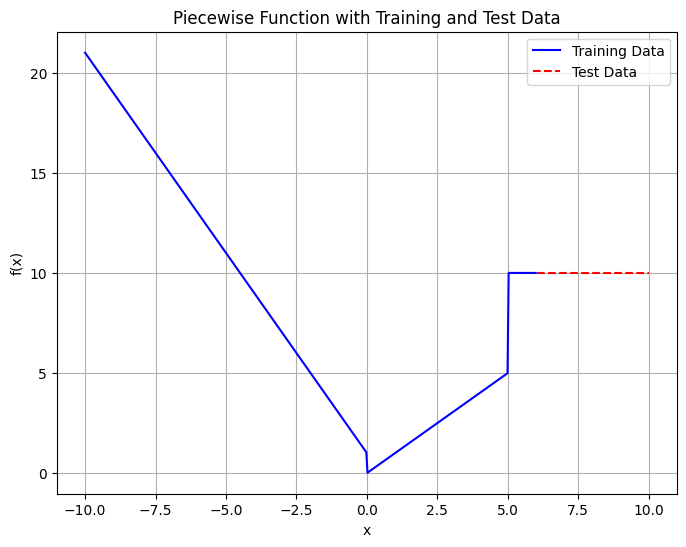

In [3]:
def piecewise_function(x):
    return np.piecewise(x, [x < 0, (x >= 0) & (x < 5), x >= 5], 
                        [lambda x: -2*x + 1,       # for x < 0
                         lambda x: x,           # for 0 <= x < 5
                         lambda x: 10]) # for x >= 5

# Generate random data points
x_data = np.random.uniform(-10, 10, 500)

# Apply the piecewise function to generate the y data
y_data = piecewise_function(x_data)

# Split the data into training and test sets (80% training, 20% testing)
split_ratio = 0.8
split_index = int(len(x_data) * split_ratio)

x_train = x_data[:split_index]
y_train = y_data[:split_index]
x_test = x_data[split_index:]
y_test = y_data[split_index:]

plt.figure(figsize=(8, 6))
plt.plot(x_train, y_train, label='Training Data', color='blue')
plt.plot(x_test, y_test, label='Test Data', color='red', linestyle='--')
plt.title('Piecewise Function with Training and Test Data')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
N = 1000
a, b = -1., 1.
X1 = jax.random.uniform(rng_key, shape=(N, 1), minval=a, maxval=b)
X2 = jax.random.uniform(rng_key, shape=(5, 1), minval=a, maxval=b)
l = 1.0

lengthscales = np.array([l])
kernel = Kernel(length_scale=lengthscales, variance=1.0, kernel_type='matern_3_2')
posterior = partial(gp_posterior, kernel=kernel)


Empirical kernel mean= [0.7763781  0.6113103  0.770221   0.61391187 0.7720505 ]
Analytic kernel mean= [[0.7676016 ]
 [0.610035  ]
 [0.7613934 ]
 [0.6147367 ]
 [0.76360416]]


In [7]:
N = 1000
a, b = -1., 1.
X1 = jax.random.uniform(rng_key, shape=(N, 1), minval=a, maxval=b)
X2 = jax.random.uniform(rng_key, shape=(5, 1), minval=a, maxval=b)
l = 1.0

K = my_RBF(X1, X2, l)
empirical_mean = jnp.mean(K, axis=0)
print('Empirical kernel mean=', empirical_mean)
analytical_mean = kme_RBF_uniform(a, b, l, X2)
print('Analytic kernel mean=', analytical_mean)


Empirical kernel mean= [0.8557096  0.68418825 0.84905046 0.68704    0.8509668 ]
Analytic kernel mean= [[0.8489164]
 [0.6807167]
 [0.8418824]
 [0.6854978]
 [0.8443825]]
